In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
import tensorflow as tf
import keras
import keras.layers as ll
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import clear_output
%matplotlib inline

Using TensorFlow backend.


In [3]:
tf_config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True), log_device_placement=True)

In [4]:
in_columns = ['S0aux7', 'S0aux6', 'S3aux0', 'S2aux0', 'S5aux0']
out_columns = ['0', '1', '2']
IN_DIM = len(in_columns)
OUT_DIM = len(out_columns)
PID = 'a'

In [5]:
BATCH_SIZE = int(1e3)
LATENT_DIMENSIONS = 3
TEST_SIZE = 0.3

In [6]:
def split_and_scale(data):
    data_train, data_val = train_test_split(data, test_size=TEST_SIZE, random_state=42)
    data_val, data_test = train_test_split(data_val, test_size=TEST_SIZE, random_state=1812)
    
    pid_test = np.array(data_test["pid"])
    
    data_train.drop("pid", axis=1, inplace=True)
    data_val.drop("pid", axis=1, inplace=True)
    data_test.drop("pid", axis=1, inplace=True)
    
    scaler = RobustScaler().fit(data_train)
    data_train = pd.DataFrame(scaler.transform(data_train.values),
                              columns=data_train.columns)
    data_val = pd.DataFrame(scaler.transform(data_val.values),
                            columns=data_val.columns)
    data_test = pd.DataFrame(scaler.transform(data_test.values),
                            columns=data_test.columns)
    
    data_test["pid"] = pid_test
    
    return data_train, data_val, data_test, scaler

In [7]:
data_all_pids = pd.read_csv("./LHCb_PID_Compression/df_full_encoded_ratio10_new_3.csv").drop('Unnamed: 0', axis=1)
data_pid = {pid: data_all_pids[data_all_pids["pid"]==pid] for pid in ["a", 'b', 'f', 'd', 'e']}

In [8]:
data_train, data_val, data_test_a, scaler = split_and_scale(data_pid['a'])
data_train, data_val, data_test_b, scaler = split_and_scale(data_pid['b'])
data_train, data_val, data_test_d, scaler = split_and_scale(data_pid['d'])
data_train, data_val, data_test_e, scaler = split_and_scale(data_pid['e'])
data_train, data_val, data_test_f, scaler = split_and_scale(data_pid['f'])

/mnt/tgaintseva/conda/envs/py3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [9]:
data_test = np.concatenate([data_test_a, data_test_b, data_test_d, data_test_e, data_test_f], axis=0)
pd.DataFrame(data_test, columns=out_columns+in_columns+['pid']).to_csv("data_test_full_new.csv", index=None)

In [10]:
len(data_test)

1194190

In [11]:
data_test = pd.read_csv("data_test_full_new.csv")
data_test.head()

,0,1,2,S0aux7,S0aux6,S3aux0,S2aux0,S5aux0,pid
0,-0.394488,0.154298,0.203296,-0.368376,-0.220542,0.0,-1000.0,0.0,a
1,0.683399,0.521921,-1.086649,-0.561989,-1.125603,-1000.0,-1000.0,0.0,a
2,-0.455241,-0.257834,-0.005435,-0.393696,-1.062180,0.0,0.0,0.0,a
3,0.300472,1.481821,-0.915191,0.856879,1.039582,0.0,0.0,-1000.0,a
4,0.287063,1.232970,-0.921626,0.205412,-0.994102,0.0,0.0,0.0,a


Let's look at the distributions of the features:

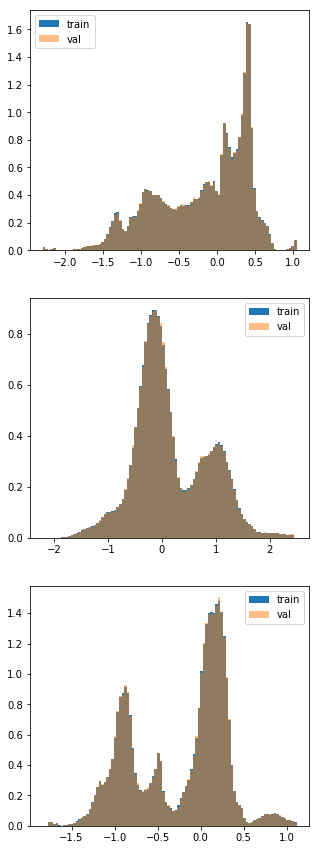

In [12]:
fig, axes = plt.subplots(3, 1, figsize=(5, 15))
for INDEX, ax in zip((0, 1, 2), axes):
    _, bins, _ = ax.hist(data_train.values[:, INDEX], bins=100, label="train", density=True)
    ax.hist(data_val.values[:, INDEX], bins=bins, label="val", alpha=0.5, density=True)
    ax.legend()
plt.show()

## Building GAN

In [13]:
data_train = data_train[in_columns+out_columns]
data_val = data_val[in_columns+out_columns]

data_test = data_test[in_columns+out_columns]

In [26]:
def get_tf_dataset(dataset, batch_size):
    shuffler = tf.contrib.data.shuffle_and_repeat(dataset.shape[0])
    suffled_ds = shuffler(tf.data.Dataset.from_tensor_slices(dataset))
    return suffled_ds.batch(batch_size).prefetch(1).make_one_shot_iterator().get_next()

In [27]:
tf.reset_default_graph()

In [28]:
def get_dense(num_layers):
    return [ll.Dense(64, activation='relu') for i in range(num_layers)]

CRAMER_DIM = 64

critic = keras.models.Sequential(
        [ll.InputLayer([OUT_DIM + IN_DIM])] + get_dense(3) +
            [ll.Dense(CRAMER_DIM)])
generator = keras.models.Sequential(
        [ll.InputLayer([LATENT_DIMENSIONS + IN_DIM])] + get_dense(3) +
            [ll.Dense(OUT_DIM)])

In [29]:
X_train_full = data_train[in_columns+out_columns]
X_train_input = data_train[in_columns]

X_train_input_tf1 = get_tf_dataset(X_train_input, BATCH_SIZE)
X_train_input_tf2 = get_tf_dataset(X_train_input, BATCH_SIZE)
X_train_full_tf = get_tf_dataset(X_train_full, BATCH_SIZE)

In [30]:
def cramer_critic(x, y):
    discriminated_x = critic(x)
    return tf.norm(discriminated_x - critic(y), axis=1) - tf.norm(discriminated_x, axis=1)

In [31]:
noise_1 = tf.random_normal([tf.shape(X_train_input_tf1)[0], LATENT_DIMENSIONS], name='noise1')
noise_2 = tf.random_normal([tf.shape(X_train_input_tf2)[0], LATENT_DIMENSIONS], name='noise2')

generated_out_1 = generator(tf.concat([noise_1, tf.cast(X_train_input_tf1, tf.float32)], axis=1))
generated_full_1 = tf.concat([tf.cast(X_train_input_tf1, tf.float32), generated_out_1], axis=1)

generated_out_2 = generator(tf.concat([noise_2, tf.cast(X_train_input_tf2, tf.float32)], axis=1))
generated_full_2 = tf.concat([tf.cast(X_train_input_tf2, tf.float32), generated_out_2], axis=1)

In [32]:
generator_loss = tf.reduce_mean(cramer_critic(tf.cast(X_train_full_tf, tf.float32), generated_full_2)
                                - cramer_critic(generated_full_1, generated_full_2))

In [33]:
with tf.name_scope("gradient_loss"):
    alpha = tf.random_uniform(shape=[tf.shape(X_train_full_tf)[0], 1], minval=0., maxval=1.)
    interpolates = alpha*tf.cast(X_train_full_tf, tf.float32) + (1.-alpha)*generated_full_1
    disc_interpolates = cramer_critic(interpolates, generated_full_2)
    gradients = tf.gradients(disc_interpolates, [interpolates])[0]
    slopes = tf.norm(tf.reshape(gradients, [tf.shape(gradients)[0], -1]), axis=1)
    gradient_penalty = tf.reduce_mean(tf.square(tf.maximum(tf.abs(slopes) - 1, 0)))

In [34]:
tf_iter = tf.Variable(initial_value=0, dtype=tf.int32)
lambda_tf = 20 / np.pi * 2 * tf.atan(tf.cast(tf_iter, tf.float32)/1e4)
critic_loss = lambda_tf*gradient_penalty - generator_loss
learning_rate = tf.train.exponential_decay(1e-3, tf_iter, 100, 0.98)
optimizer = tf.train.RMSPropOptimizer(learning_rate)
critic_train_op = optimizer.minimize(critic_loss, var_list=critic.trainable_weights)
generator_train_op = tf.group(
    optimizer.minimize(generator_loss, var_list=generator.trainable_weights),
    tf.assign_add(tf_iter, 1))

In [35]:
tf.summary.scalar("critic_loss", tf.reshape(critic_loss, []))
tf.summary.scalar("generator_loss", tf.reshape(generator_loss, []))
tf.summary.scalar("learning_rate", learning_rate)
tf.summary.scalar("lambda", lambda_tf)
merged_summary = tf.summary.merge_all()

In [36]:
N_VAL = int(1e4)
validation_np = data_val.sample(N_VAL).values

In [37]:
data_val.sample(N_VAL).head()

,S0aux7,S0aux6,S3aux0,S2aux0,S5aux0,0,1,2
15215,-0.378492,-0.895709,0.0,0.0,0.0,-1.609454,0.702398,1.037247
416031,-0.125065,0.136252,0.0,0.0,0.0,-0.932555,-0.385299,0.187694
119844,-0.307170,0.194859,0.0,0.0,0.0,-0.649495,-0.887380,-0.094623
76972,0.107594,0.172956,0.0,0.0,0.0,0.099865,-0.545605,0.013411
10686,-0.181041,-1.122483,-1000.0,-1000.0,0.0,0.696518,1.032155,-0.890381


In [38]:
var_init = tf.global_variables_initializer()
weights_saver = tf.train.Saver()

In [39]:
tf.get_default_graph().finalize()

## Training GAN

In [49]:
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 64)                576       
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 195       
Total params: 9,091
Trainable params: 9,091
Non-trainable params: 0
_________________________________________________________________


In [23]:
MODEL_NAME = "GAN_Kramer_dim3_bs1e3_l3_ld3_new".format(PID)
LOGDIR = "/mnt/tgaintseva/compression/tensorboard_logdir"
CRITIC_ITERATIONS_CONST = 15
CRITIC_ITERATIONS_VAR = 0
TOTAL_ITERATIONS = int(1e5)
VALIDATION_INTERVAL = 100
MODEL_WEIGHTS_FILE = "weights/%s.ckpt" % MODEL_NAME
train_writer = tf.summary.FileWriter(os.path.join(LOGDIR, MODEL_NAME, "train"))
test_writer = tf.summary.FileWriter(os.path.join(LOGDIR, MODEL_NAME, "test"))
critic_policy = lambda i: (
    CRITIC_ITERATIONS_CONST + (CRITIC_ITERATIONS_VAR * (TOTAL_ITERATIONS - i)) // TOTAL_ITERATIONS)

Look at the result distributions:

In [50]:
with tf.Session(config=tf_config) as sess:
    sess.run(var_init)
    try:
        weights_saver.restore(sess, MODEL_WEIGHTS_FILE)
    except tf.errors.NotFoundError:
        print("Can't restore parameters: no file with weights")
    test_summary, test_generated = sess.run([merged_summary, generated_out_1], {
        X_train_input_tf1: data_test.values[:, :len(in_columns)],
        X_train_input_tf2: data_test.values[:, :len(in_columns)], X_train_full_tf: data_test})
    fig, axes = plt.subplots(3, 1, figsize=(5, 15))
    for INDEX, ax in zip((0, 1, 2), axes):
        _, bins, _ = ax.hist(validation_np[:, INDEX+len(in_columns)], bins=100, label="data", density=True)
        ax.hist(test_generated[:, INDEX], bins=bins, label="generated", alpha=0.5, density=True)
        ax.legend()
        ax.set_title(out_columns[INDEX])
    plt.show()

INFO:tensorflow:Restoring parameters from weights/GAN_Kramer_dim3_bs1e3_l3_ld3_new_pida.ckpt
Can't restore parameters: no file with weights


KeyboardInterrupt: 

## XGBoost for PID Classification

In [14]:
from helpers import *

In [46]:
with tf.Session(config=tf_config) as sess:
    sess.run(var_init)
    weights_saver.restore(sess, MODEL_WEIGHTS_FILE)
    sess.graph._unsafe_unfinalize()
    tf.get_default_graph().finalize()

INFO:tensorflow:Restoring parameters from weights/GAN_Kramer_dim3_bs1e3_l3_ld3_pida.ckpt


Prepare data:

In [16]:
data_test_pid_a = np.array(pd.read_csv('df_GAN_dim3_new_pida.csv'))
data_test_pid_b = np.array(pd.read_csv('df_GAN_dim3_new_pidb.csv'))
data_teчst_pid_f = np.array(pd.read_csv('df_GAN_dim3_new_pidf.csv'))
data_test_pid_d = np.array(pd.read_csv('df_GAN_dim3_new_pidd.csv'))
data_test_pid_e = np.array(pd.read_csv('df_GAN_dim3_new_pide.csv'))

data_test = np.concatenate([data_test_pid_a, data_test_pid_b, data_test_pid_d, data_test_pid_e, data_test_pid_f], axis=0)
data_test = pd.DataFrame(data_test, columns=out_columns+in_columns+['pid'])
data_test.head()

,0,1,2,S0aux7,S0aux6,S3aux0,S2aux0,S5aux0,pid
0,0.0233203,0.134563,-0.109176,-0.368376,-0.220542,0,-1000,0,a
1,1.02467,0.269171,-0.936094,-0.561989,-1.1256,-1000,-1000,0,a
2,0.199015,1.07077,-0.845934,-0.393696,-1.06218,0,0,0,a
3,-0.749295,-0.30129,-0.279682,0.856879,1.03958,0,0,-1000,a
4,-1.50694,0.676668,0.768091,0.205412,-0.994102,0,0,0,a


In [17]:
data_test_orig = pd.read_csv("data_test_full_new.csv")
data_test_orig.head()

,0,1,2,S0aux7,S0aux6,S3aux0,S2aux0,S5aux0,pid
0,-0.394488,0.154298,0.203296,-0.368376,-0.220542,0.0,-1000.0,0.0,a
1,0.683399,0.521921,-1.086649,-0.561989,-1.125603,-1000.0,-1000.0,0.0,a
2,-0.455241,-0.257834,-0.005435,-0.393696,-1.062180,0.0,0.0,0.0,a
3,0.300472,1.481821,-0.915191,0.856879,1.039582,0.0,0.0,-1000.0,a
4,0.287063,1.232970,-0.921626,0.205412,-0.994102,0.0,0.0,0.0,a


In [18]:
data_test_input = data_test[in_columns]
data_test_out = data_test[out_columns]
data_test_full = data_test[in_columns+out_columns]
pid_test = data_test["pid"]

Split to train/test for xgboost:

In [19]:
le = LabelEncoder()
y = le.fit_transform(pid_test)

In [20]:
test_size = 0.3

idx_train_clf, idx_test_clf = train_test_split(np.arange(data_test_full.shape[0]), stratify=y, 
                                               random_state=42, test_size=test_size)
X_train, X_test = np.array(data_test_out)[idx_train_clf], np.array(data_test_out)[idx_test_clf]
X_train_gen, X_test_gen = np.array(data_test_orig[out_columns])[idx_train_clf], np.array(data_test_orig[out_columns])[idx_test_clf]
y_train, y_test = y[idx_train_clf], y[idx_test_clf]

In [21]:
metrics_dict = {
    # ROC
    'fpr': defaultdict(dict),
    'tpr': defaultdict(dict),
    'roc_auc': defaultdict(dict),

    # PR
    'precision': defaultdict(dict), 
    'recall': defaultdict(dict),
    'pr_auc': defaultdict(dict),

    'f_measure': {},
    'acc': {}
}

In [24]:
path_to_metrics = './metrics/'
metrics_dir_name = MODEL_NAME

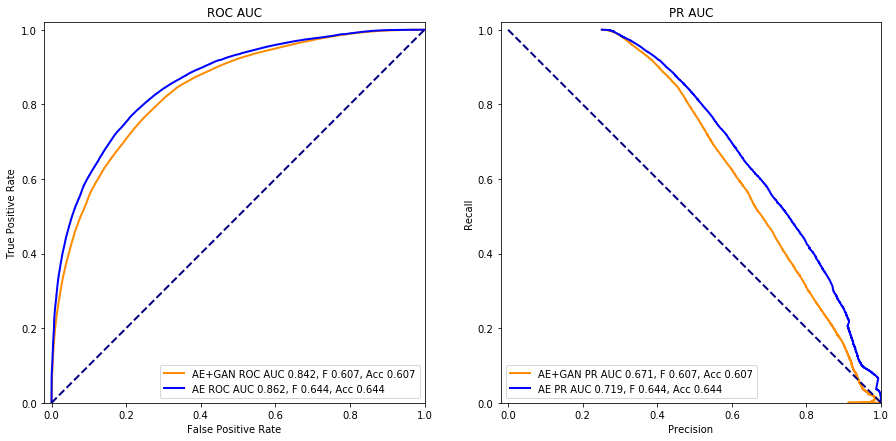

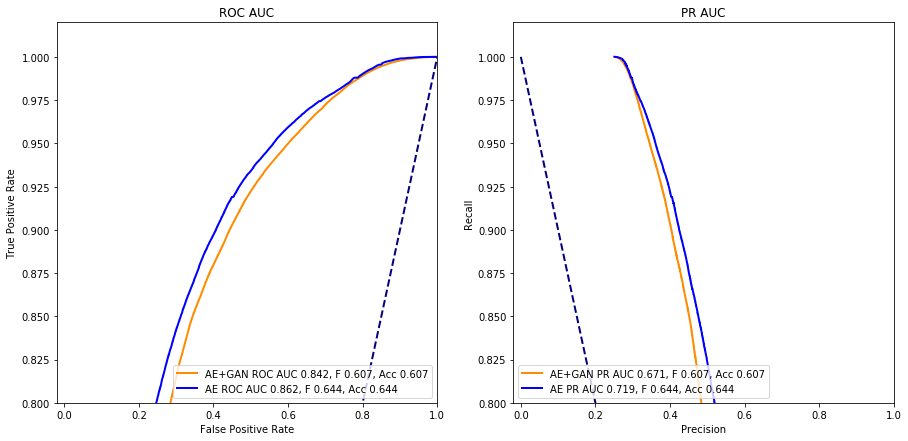

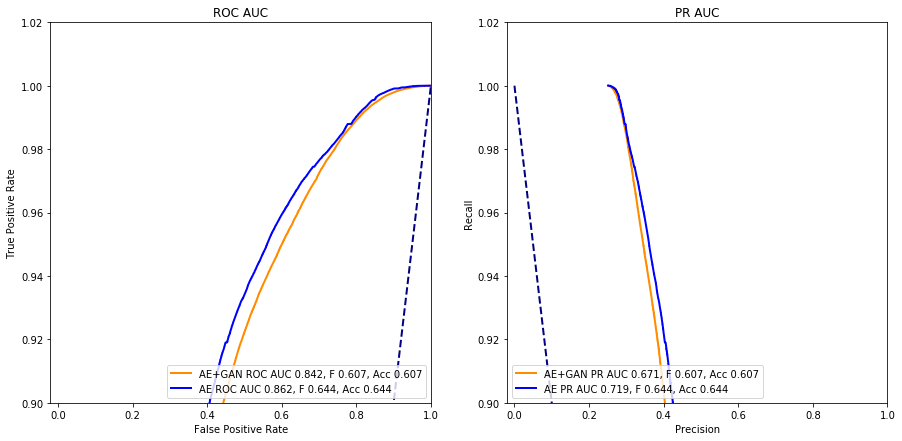

100%|██████████| 2/2 [05:53<00:00, 177.00s/it]


In [25]:
from tqdm import tqdm
for encoding_dim in tqdm(["AE+GAN", "AE"]):
    clf_name = "XGBoost_{}".format(encoding_dim)
    clf = xgb.XGBClassifier(nthread=-1, seed=111)
    
    if encoding_dim == "AE":
        clf.fit(X_train, y_train)
        y_proba = clf.predict_proba(X_test)
    else:
        clf.fit(X_train_gen, y_train)
        y_proba = clf.predict_proba(X_test_gen)
    y_bin = label_binarize(y_test, classes=np.unique(y_test))
    y_pred = np.argmax(y_proba, axis=1)
    
    # Compute ROC/PR curve and ROC/PR area for each class
    for pid_label in np.unique(y_test):
        idx = np.where(y_test == pid_label)[0]
        cur_y = np.where(y_test == pid_label, np.ones_like(y_test), np.zeros_like(y_test))
        cur_y_proba = y_proba[:, pid_label]
        
        pid_label = str(pid_label)
        metrics_dict['fpr'][encoding_dim][pid_label], metrics_dict['tpr'][encoding_dim][pid_label], _ = \
            roc_curve(cur_y, cur_y_proba)
        metrics_dict['precision'][encoding_dim][pid_label], metrics_dict['recall'][encoding_dim][pid_label], _ = \
            precision_recall_curve(cur_y, cur_y_proba)
        
    metrics_dict['fpr'][encoding_dim]["micro"], metrics_dict['tpr'][encoding_dim]["micro"], _ = \
        roc_curve(y_bin.ravel(), y_proba.ravel())
    metrics_dict['precision'][encoding_dim]["micro"], metrics_dict['recall'][encoding_dim]["micro"], _ = \
        precision_recall_curve(y_bin.ravel(), y_proba.ravel())
    
    metrics_dict['roc_auc'][encoding_dim]["micro"] = auc(
        metrics_dict['fpr'][encoding_dim]["micro"], metrics_dict['tpr'][encoding_dim]["micro"])
    metrics_dict['pr_auc'][encoding_dim]["micro"] = average_precision_score(y_bin.ravel(), y_proba.ravel())
    
    metrics_dict['f_measure'][encoding_dim] = f1_score(y_test, y_pred, average='micro')
    metrics_dict['acc'][encoding_dim] = accuracy_score(y_test, y_pred)
    
    # Save
    dump_metrics(path_to_metrics, metrics_dir_name, metrics_dict)
    
    # Plot
    display.clear_output(wait=True)
    plot_metrics(metrics_dict, pid_label='micro', xlim=(-0.02, 1), ylim=(0, 1.02))
    plot_metrics(metrics_dict, pid_label='micro', xlim=(-0.02, 1), ylim=(0.8, 1.02))
    plot_metrics(metrics_dict, pid_label='micro', xlim=(-0.02, 1), ylim=(0.9, 1.02))